In [2]:
import os
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [3]:
# Đọc tệp CSV đã tải lên
file_path = 'preProcessedDataWithHmdx.csv'
data = pd.read_csv(file_path)

# Hiển thị thông tin tổng quan về dữ liệu
data.info(), data.head()
data = data.drop(columns=['HMDX_label'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3439 non-null   int64  
 1   Month             3439 non-null   int64  
 2   Day               3439 non-null   int64  
 3   Temp_mean         3439 non-null   float64
 4   DewPoint_mean     3439 non-null   float64
 5   RelHum_mean       3439 non-null   float64
 6   PrecipAmount_sum  3439 non-null   float64
 7   StnPress_mean     3439 non-null   float64
 8   HMDX              3439 non-null   float64
 9   HMDX_label        3439 non-null   object 
 10  Temp_range        3439 non-null   float64
 11  DewPoint_range    3439 non-null   float64
 12  RelHum_range      3439 non-null   float64
 13  StnPress_range    3439 non-null   float64
dtypes: float64(10), int64(3), object(1)
memory usage: 376.3+ KB


In [4]:
# Tính ma trận tương quan
correlation_matrix = data.corr()

# Xác định các cặp thuộc tính có tương quan lớn hơn 0.75
high_corr_pairs = correlation_matrix[correlation_matrix.abs() > 0.75].stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]

# Lọc danh sách các cột cần loại bỏ
columns_to_drop = set()
for col1, col2, corr in high_corr_pairs.itertuples(index=False):
    # Chỉ giữ lại một cột trong mỗi cặp
    if col1 not in columns_to_drop:
        columns_to_drop.add(col2)

# Loại bỏ các cột có tương quan cao
filtered_data = data.drop(columns=list(columns_to_drop), axis=1)
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3439 non-null   int64  
 1   Month             3439 non-null   int64  
 2   Day               3439 non-null   int64  
 3   Temp_mean         3439 non-null   float64
 4   RelHum_mean       3439 non-null   float64
 5   PrecipAmount_sum  3439 non-null   float64
 6   StnPress_mean     3439 non-null   float64
 7   Temp_range        3439 non-null   float64
 8   DewPoint_range    3439 non-null   float64
 9   RelHum_range      3439 non-null   float64
 10  StnPress_range    3439 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 295.7 KB


In [5]:
# Kết hợp các cột Year, Month, Day thành một cột Date
filtered_data['Date'] = pd.to_datetime(filtered_data[['Year', 'Month', 'Day']])

# Đặt cột 'Date' làm chỉ số thời gian
filtered_data.set_index('Date', inplace=True)

# Xóa các cột không cần thiết
filtered_data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

train_data = filtered_data.iloc[:-30]['Temp_mean']
test_data = filtered_data.iloc[-30:]['Temp_mean']

In [6]:
result = adfuller(train_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.5734113117091613
p-value: 0.006290171101920332


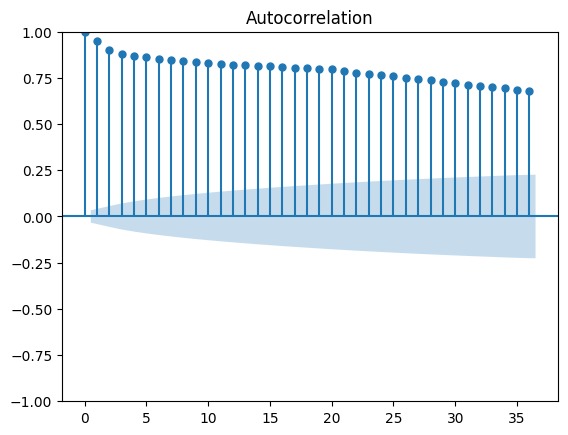

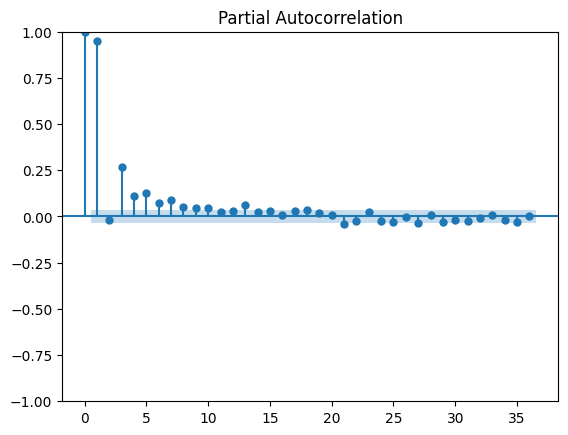

In [7]:
plot_acf(train_data)
plot_pacf(train_data)
plt.show()

In [ ]:
# Tạo thư mục lưu đồ thị nếu chưa tồn tại
output_dir = "../arima_forecasts"
os.makedirs(output_dir, exist_ok=True)

# Vòng lặp thử nghiệm các giá trị p, d, q
for p in range(8):
    for d in range(8):
        for q in range(8):
            try:
                # Xây dựng và huấn luyện mô hình ARIMA
                model = ARIMA(train_data, order=(p, d, q))
                model_fit = model.fit()

                # Dự đoán
                forecast = model_fit.forecast(steps=30)

                # Vẽ đồ thị
                plt.figure(figsize=(12, 6))
                plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
                plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
                plt.xlabel('Date')
                plt.ylabel('Temperature Mean')
                plt.title(f'ARIMA Forecast (p={p}, d={d}, q={q})')
                plt.legend()
                plt.grid()

                # Lưu đồ thị
                file_name = f"arima_p{p}_d{d}_q{q}.png"
                plt.savefig(os.path.join(output_dir, file_name))
                plt.close()
            except Exception as e:
                print(f"Failed for ARIMA(p={p}, d={d}, q={q}): {e}")


In [ ]:
# Tạo thư mục lưu đồ thị nếu chưa tồn tại
output_dir = "../sarima_forecasts"
os.makedirs(output_dir, exist_ok=True)

P,D,Q,S=1,1,1,12

for p in range(8):
    for d in range(8):
        for q in range(8):
            try:
                # Xây dựng và huấn luyện mô hình SARIMA
                sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
                sarima_fit = sarima_model.fit()

                # Dự đoán
                forecast_sarima = sarima_fit.forecast(steps=30)

                # Vẽ đồ thị
                plt.figure(figsize=(12, 6))
                plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
                plt.plot(test_data.index, forecast_sarima, label='Forecast', color='red', linestyle='--')
                plt.xlabel('Date')
                plt.ylabel('Temperature Mean')
                plt.title(f'SARIMA Forecast (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S})')
                plt.legend()
                plt.grid()

                # Lưu đồ thị
                file_name = f"sarima_p{p}_d{d}_q{q}_P{P}_D{D}_Q{Q}_S{S}.png"
                plt.savefig(os.path.join(output_dir, file_name))
                plt.close()
            except Exception as e:
                print(f"Failed for SARIMA(p={p}, d={d}, q={q}): {e}")

In [ ]:
output_dir = "../sarima_forecasts_2"
os.makedirs(output_dir, exist_ok=True)

S = 12

# Vòng lặp thử nghiệm các giá trị (p, d, q) và (P, D, Q)
for p in range(3):  # Điều chỉnh phạm vi nếu cần
    for d in range(3):
        for q in range(3):
            for P in range(3):  # Điều chỉnh phạm vi của P
                for D in range(3):  # Điều chỉnh phạm vi của D
                    for Q in range(3):  # Điều chỉnh phạm vi của Q
                        try:
                            # Xây dựng và huấn luyện mô hình SARIMA
                            sarima_model = SARIMAX(
                                train_data, 
                                order=(p, d, q), 
                                seasonal_order=(P, D, Q, S)
                            )
                            sarima_fit = sarima_model.fit(disp=False)

                            # Dự đoán
                            forecast_sarima = sarima_fit.forecast(steps=30)

                            # Vẽ đồ thị
                            plt.figure(figsize=(12, 6))
                            plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
                            plt.plot(test_data.index, forecast_sarima, label='Forecast', color='red', linestyle='--')
                            plt.xlabel('Date')
                            plt.ylabel('Temperature Mean')
                            plt.title(f'SARIMA Forecast (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S})')
                            plt.legend()
                            plt.grid()

                            # Lưu đồ thị
                            file_name = f"sarima_p{p}_d{d}_q{q}_P{P}_D{D}_Q{Q}_S{S}.png"
                            plt.savefig(os.path.join(output_dir, file_name))
                            plt.close()
                        except Exception as e:
                            print(f"Failed for SARIMA(p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")


C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\loca

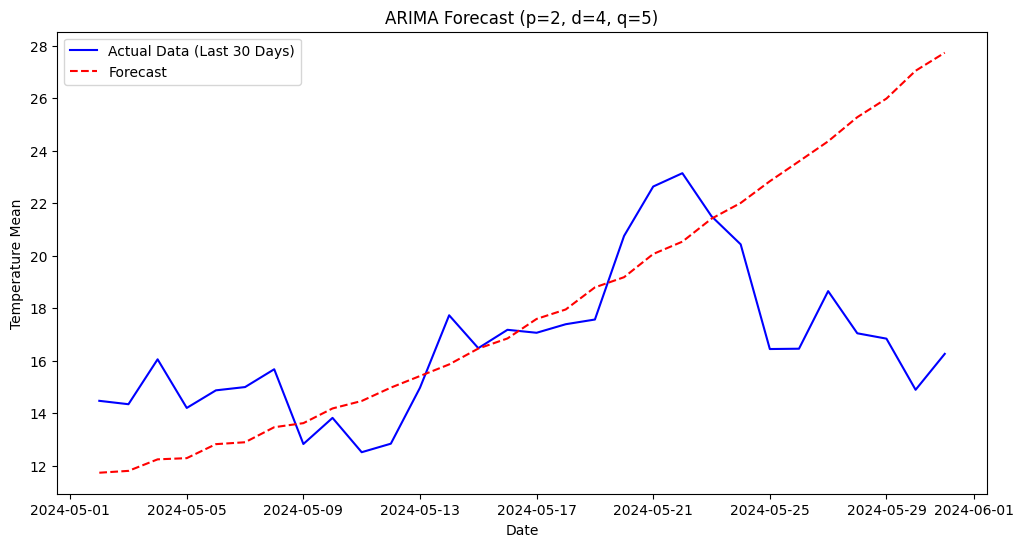

In [9]:
p, d, q = 2, 4, 5
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Dự đoán
forecast = model_fit.forecast(steps=30)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'ARIMA Forecast (p={p}, d={d}, q={q})')
plt.legend()
plt.show()

C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


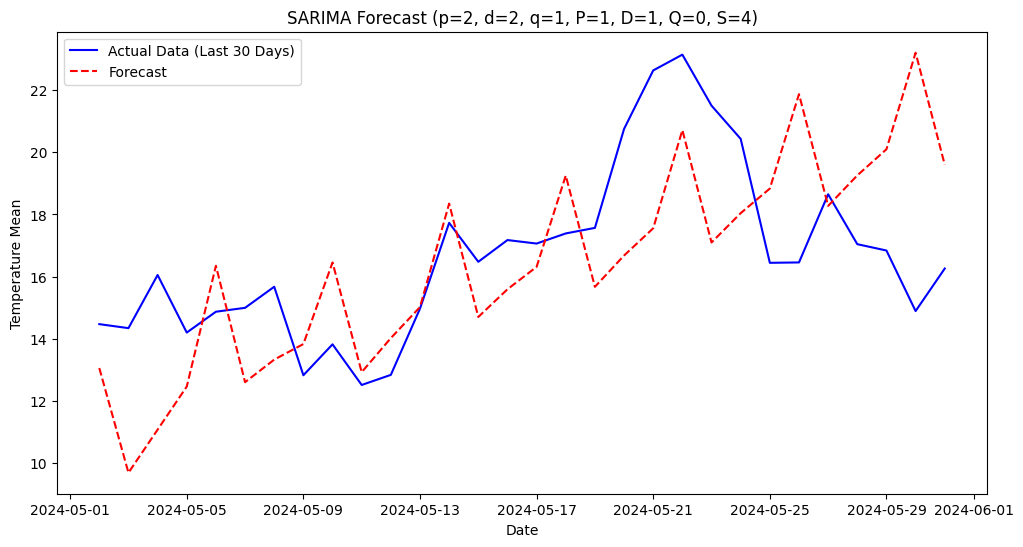

In [12]:
p, d, q, P, D, Q, S = 2, 2, 1, 1, 1, 0, 4

sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_fit = sarima_model.fit(disp=False)

# Dự đoán
forecast_sarima = sarima_fit.forecast(steps=30)
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_sarima, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'SARIMA Forecast (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S})')
plt.legend()
plt.show()